In [1]:
# Basic Imports
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
import json
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
from scipy.stats import norm, beta
import matplotlib.pyplot as plt


# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

wandb_dir = os.path.join(os.path.expanduser('~'), "PFGMPP")
os.environ["WANDB_DIR"] = os.path.abspath(wandb_dir)

# Goal

The goal for this notebook was to double check Davids intuition about how likelihoods would be distributed uniformly. To do this we use a simple normal distribution. We sample from said distribution, calculated the LL of those samples being from a normal distribution, and plot the resulting likelihoods.

The reason we do this test is because using the ODE formulation for SBGM allows one to do exact likelihood computation and in the [JAX colab notebook](https://colab.research.google.com/drive/1SeXMpILhkJPjXUaesvzEhc3Ke6Zl_zxJ?usp=sharing) of Yang Song they don't visualize the LL distribution, but rather just calculate it for a batch of samples. Because of this lack of visualization David wanted to make sure the LL computation was correct and the way to do that (**he thinks**), is to see if the likelihoods are normally distributed.

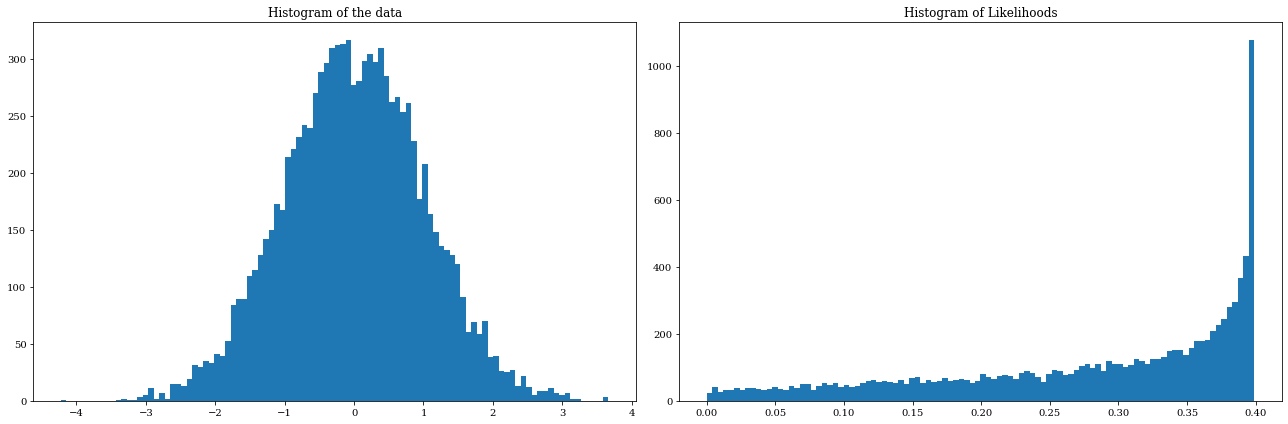

In [2]:
# Generate some data from a normal distribution
xs = np.random.normal(size=(10000,))

# Function to compute the Gaussian likelihood
def gauss_LL(x):
    LL = (1 / np.sqrt(2*np.pi)) * np.exp(-x**2 / 2)
    return LL

# Compute the likelihoods
likelihoods = gauss_LL(xs)
# likelihoods = norm.pdf(xs, loc=0, scale=1)

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram of the data on the first subplot
axes[0].hist(xs, bins=100)
axes[0].set_title("Histogram of the data")
axes[1].hist(likelihoods, bins=100)
axes[1].set_title("Histogram of Likelihoods")

# Show both plots
plt.tight_layout()
plt.show()

# Main Results

We see that the distribution of likelihoods are **NOT** uniformly distributed, but rather has a large peak of values of $\sim 0.40$. 

**Why is this the case?**
- It is due to the fact that the likelihoods will be higher for points closer to the mean ($0$ in this case), since the points are more "likely" under a Gaussian distribution centered around the mean.
    - Note that the value of $0.40$ is in fact the LL of 0 i.e.:
      $$f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \text{exp}(-\frac{(x-\mu)^2}{2\sigma^2}) $$
      $$f(x | \mu=0, \sigma^2=1) = \frac{1}{\sqrt{2\pi}} \text{exp}(-\frac{(x-0)^2}{2}) $$
      $$f(x=0 | 0, 1) = \frac{1}{\sqrt{2\pi}} \text{exp}(0) = \frac{1}{\sqrt{2\pi}} \approx 0.40$$
- The likelihoods of samples from a Gaussian distribution will themselves follow a distribution that reflects the shape of the original Gaussian distribution, peaked around the mean.


# Outlier testing

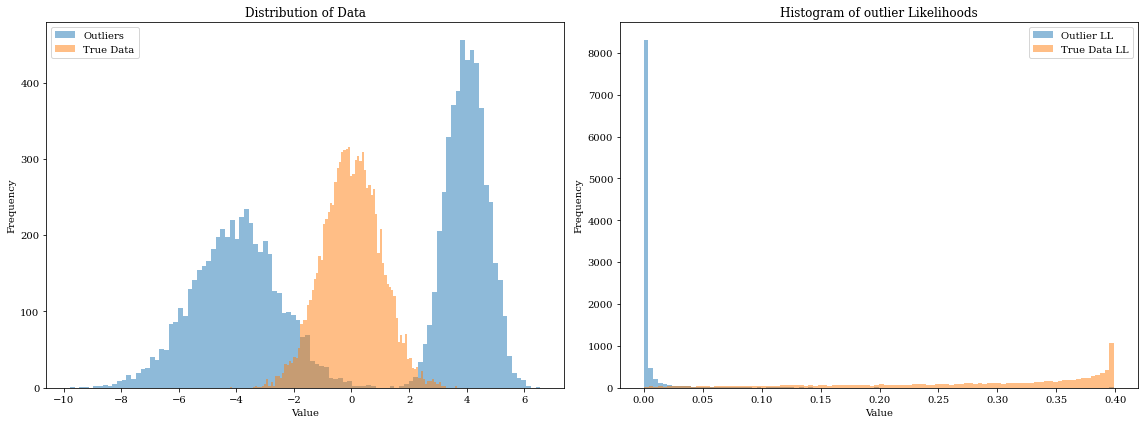

In [6]:
samples1 = np.random.normal(-4, 1.5, size=(5000,))
samples2 = np.random.normal(4, 0.7, size=(5000,))
outlier_arr = np.concatenate([samples1, samples2])

outlier_LL = gauss_LL(outlier_arr)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the histogram of the data on the first subplot
axes[0].hist(outlier_arr, alpha=0.5, bins=100, label='Outliers')
axes[0].hist(xs, alpha=0.5, bins=100, label='True Data')
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Data")
axes[0].legend()

axes[1].hist(outlier_LL, bins=100, alpha=0.5, label='Outlier LL')
axes[1].hist(likelihoods, bins=100, alpha=0.5, label='True Data LL')
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of outlier Likelihoods")
axes[1].legend()

# Show both plots
plt.tight_layout()
plt.show()

**Results:**
- See that our mixture model has very low probability (see the large blue peak centered at 0 on the right plot). Which makes sense because there is very little overlap between the original Gaussian distribution (orange) and the mixture models samples (in blue).